In [1]:
import os
import cpi
import helper
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.core.pylabtools import figsize
figsize(10, 6)

# General

## Median Wages
Raw data pulled from [here](https://docs.google.com/spreadsheets/d/14LXh9kOZk8DF_gZxpS6ljgKf2PoTHwGtTVc4_6PTJxA/edit#gid=1618676625)

In [3]:
median_wages = pd.read_csv("../raw_data/median_wages.txt", sep="|")
median_wages["Date"] = pd.to_datetime(median_wages["Year"], format='%Y')
median_wages = median_wages.sort_values(by="Date").reset_index(drop=True)

median_wages = helper.percent_change_relative_to(median_wages, date="1970-01-01", column_name="Median earnings (FtM)")

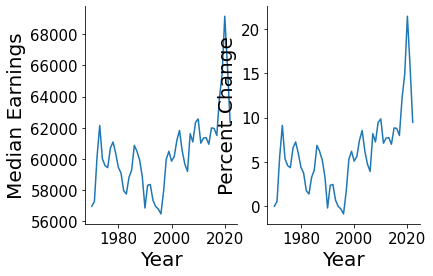

In [4]:
plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Median earnings (FtM)", data=median_wages)
plt.ylabel("Median Earnings")

plt.subplot(1, 2, 2)
sns.lineplot(x="Year", y="Percent Change", data=median_wages);

### Median home price
Data pulled from [FRED](https://fred.stlouisfed.org/series/MSPUS)

In [5]:
median_home_price = pd.read_csv("../raw_data/government/median_home_price.csv")
median_home_price["Date"] = pd.to_datetime(median_home_price["Date"], format="mixed")
median_home_price = median_home_price["Median Home Price"].groupby(median_home_price["Date"].dt.year).mean().reset_index()

median_home_price = median_home_price.rename(columns={"Date": "Year"})

# Adjust for inflation
median_home_price["Median Home Price"] = median_home_price.apply(
    lambda x: cpi.inflate(x["Median Home Price"], int(x.Year), to=2023), axis=1
)

<Axes: xlabel='Year', ylabel='Median Home Price'>

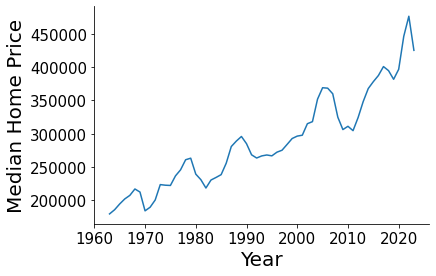

In [6]:
sns.lineplot(x="Year", y="Median Home Price", data=median_home_price)

<Axes: xlabel='Year', ylabel='Percent Change'>

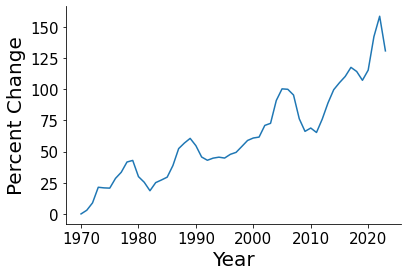

In [7]:
median_home_price = helper.percent_change_relative_to(median_home_price, 1970, "Median Home Price")
sns.lineplot(x="Year", y="Percent Change", data=median_home_price)

### Household Income
Raw data pulled from [here](https://www2.census.gov/programs-surveys/demo/tables/p60/279/tableA4.xlsx)

In [8]:
percentiles = ["20", "50 (Median)", "95"]
household_income = pd.read_csv("../raw_data/household_income.txt", sep="|").drop(columns=["90th/10th", "90th/50th", "50th/10th"])

household_income = household_income[["Year"] + percentiles]
household_income = pd.melt(household_income, id_vars=["Year"], var_name="Percentile", value_name="Income")

household_income["Date"] = pd.to_datetime(household_income["Year"], format='%Y')
household_income = household_income.sort_values(by="Date").reset_index(drop=True)

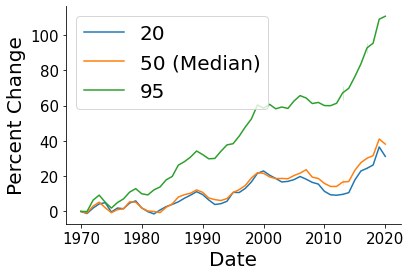

In [9]:
for percentile in percentiles:
    df = household_income[household_income.Percentile == percentile].reset_index(drop=True)
    df = helper.percent_change_relative_to(df, "1970-01-01", "Income")

    sns.lineplot(x="Date", y="Percent Change", data=df, label=percentile)

## Population

In [10]:
population = pd.read_csv("../raw_data/government/population.csv")
population = population.sort_values("Year").reset_index(drop=True)

# Regulation

## Banking
### Inflation

In [11]:
df = pd.read_csv("../raw_data/government/inflation_data.csv")
df.head()

,year,amount,inflation rate
0,1912,1.00,0.02
1,1913,1.02,0.02
2,1914,1.03,0.01
3,1915,1.04,0.01
4,1916,1.12,0.08


### Consumer Price Index (CPI)
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SA0?years_option=all_years) 

In [12]:
cpi_data = pd.read_excel("../raw_data/government/cpi.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
cpi_data = helper.format_year_month_table(cpi_data, "CPI")

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
dates = [datetime.datetime.utcfromtimestamp((x - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')) for x in cpi_data.Date.values]
purchasing_power = np.array([cpi.inflate(1, date, to=datetime.date(2023, 1, 1)) for date in dates])

In [14]:
crop = 30
one_dollar = plt.imread("../raw_data/government/banking/one_dollar.jpg")[crop:-crop, crop:-crop]
one_dollar = np.copy(one_dollar)

In [15]:
column_width = one_dollar.shape[1] / len(dates)
column_indices = column_width * np.arange(len(dates))
column_indices = column_indices.astype(int)

row_spacing = one_dollar.shape[0] / purchasing_power[0]

x, y = [], []
for index in range(len(purchasing_power)):
    row_index = one_dollar.shape[0] - int(purchasing_power[index] * row_spacing)

    start = column_indices[index]
    end = one_dollar.shape[1]
    if index != len(purchasing_power) - 1:
        end = column_indices[index+1]

    one_dollar[:row_index, start:end] = 255.
    x.append(row_index)
    y.append(start)

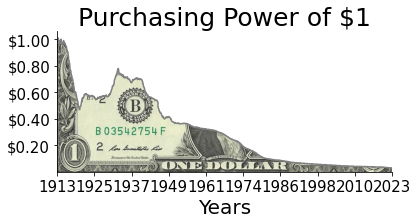

In [16]:
plt.imshow(one_dollar, cmap="gray")
plt.plot(y, x, color="gray")
plt.title("Purchasing Power of $1", fontsize=25)
plt.xlabel("Years")
plt.xticks(np.linspace(0, one_dollar.shape[1], 10), np.linspace(1913, 2023, 10).astype(int));

y_labels = [f"${label:.2f}" for label in np.linspace(0.2, 1, 5).round(3)[::-1]]
plt.yticks(np.linspace(0, one_dollar.shape[0], 6)[:-1], y_labels);

plt.savefig("../images/purchasing_power.png")

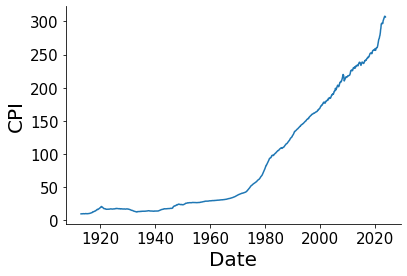

In [17]:
sns.lineplot(x="Date", y="CPI", data=cpi_data);

### Money Supply
Data from FRED

In [18]:
m0 = pd.read_csv("../raw_data/government/banking/monetary_base.csv")
m0["Date"] = pd.to_datetime(m0["Date"], format="mixed")
m0["Billions of Dollars"] = m0["Millions of Dollars"] / 1_000

m1 = pd.read_csv("../raw_data/government/banking/m1.csv")
m1["Date"] = pd.to_datetime(m1["Date"], format="mixed")

m2 = pd.read_csv("../raw_data/government/banking/m2.csv")
m2["Date"] = pd.to_datetime(m2["Date"], format="mixed")

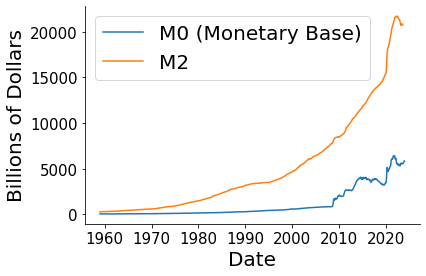

In [19]:
sns.lineplot(x="Date", y="Billions of Dollars", data=m0, label="M0 (Monetary Base)")
# sns.lineplot(x="Date", y="Billions of Dollars", data=m1)
sns.lineplot(x="Date", y="Billions of Dollars", data=m2, label="M2")

plt.legend(fontsize=20);

## Aviation

### Airports
Data from the [Bureau of Transportation Statistics](https://www.bts.gov/content/number-us-airportsa)

In [20]:
airports = pd.read_csv("../raw_data/government/aviation/airports.txt")

Text(0, 0.5, 'Public Airports')

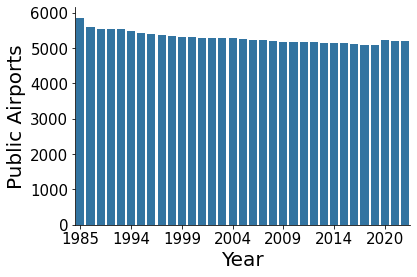

In [21]:
ax = sns.barplot(x="Year", y="Public", data=airports)

ax.set_xticks(range(0, len(airports), 5), airports.Year.values[::5])
plt.ylabel("Public Airports")

### 200 busiest airports
Airport rankings pulled from [BTS](https://www.bts.gov/topics/airlines-and-airports/airport-rankings-2022) airport dates found manually

In [22]:
airports = pd.read_excel("../raw_data/government/aviation/top_200_airports.xlsx", skiprows=2)
airports.Opened = airports.Opened.fillna(0.0).astype(int)
airports = airports.replace(0, None)

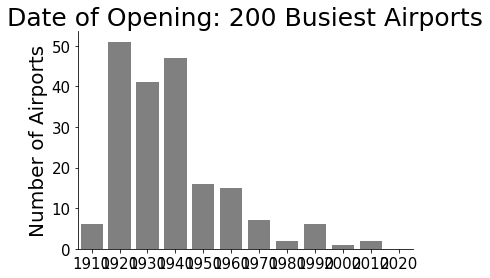

In [23]:
counts = airports["Opened"].value_counts().to_frame().reset_index().sort_values(by="Opened")
counts = counts.groupby((counts["Opened"]//10)*10).sum().drop(columns=["Opened"]).reset_index()
counts = pd.concat([counts, pd.DataFrame({"Opened": [2020], "count": [0]})])

ax = sns.barplot(x="Opened", y="count", data=counts, color="gray")
plt.xlabel("")
plt.title("Date of Opening: 200 Busiest Airports", fontsize=25)
plt.ylabel("Number of Airports");

plt.savefig("../images/busiest_airport_opening.png")

### Commercial Aviation Fatalities Over Time
Raw data pulled from [here](https://en.wikipedia.org/wiki/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States)  
General aviation data available [here](https://www.bts.gov/content/us-general-aviationa-safety-data)

In [24]:
df = pd.read_csv("../raw_data/government/aviation/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States.csv", sep="\t")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df["Fatalities"] = df["Fatalities"].replace(",", "").astype(float)

# Remove September 11th flights
df = df[df["Date"] != "2001-09-11"]
df = df[df.Date > "1950-01-01"]
df.head()

,Date,Fatalities,Injuries,Survivors,Flight(s) or incident,Location,State or territory,Aircraft,Summary
0,2023-06-23,1.0,0,0,2023 San Antonio ground crew suicide incident,San Antonio,Texas,Airbus A319,A ground crewman was ingested into an engine o...
1,2022-12-31,1.0,0,0,2022 Montgomery ground crew incident,Montgomery,Alabama,Embraer 175,An airline worker was pulled into the engine o...
2,2022-09-04,10.0,0,0,2022 Mutiny Bay DHC-3 Otter crash,Mutiny Bay near Whidbey Island,Washington,de Havilland Canada DHC-3 Otter,"Carrying tourists, the seaplane nosedived and ..."
3,2020-05-07,1.0,0,58,Southwest Airlines Flight 1392,Austin,Texas,Boeing 737-700,A man who had illegally entered the airfield w...
4,2020-01-26,9.0,0,0,2020 Calabasas helicopter crash,Calabasas,California,Sikorsky S-76B,The chartered helicopter flight crashed in hea...


In [25]:
fatalities_per_decade = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
for year in range(1950, 2024):
    if len(fatalities_per_decade[fatalities_per_decade.Date == year]) != 0:
        continue 

    fatalities_per_decade.loc[-1] = [year, 0]
    fatalities_per_decade.index = fatalities_per_decade.index + 1
    fatalities_per_decade = fatalities_per_decade.sort_index()

    fatalities_per_decade = fatalities_per_decade.sort_values(by="Date").reset_index(drop=True)

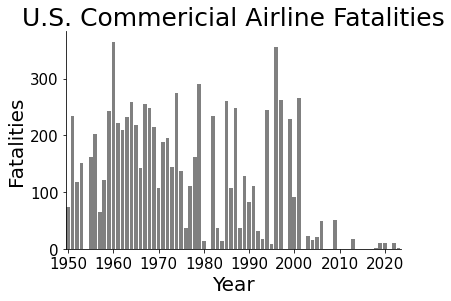

In [26]:
# fatalities_per_year = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
plt.title("U.S. Commericial Airline Fatalities", fontsize=25)
ax = sns.barplot(x="Date", y="Fatalities", data=fatalities_per_decade, color="gray")

years = sorted(fatalities_per_decade["Date"].unique())
ax.set_xticks(range(0, len(years), 10), years[::10]);
plt.xlabel("Year")

plt.savefig("../images/us_commercial_airline_fatalities.png")

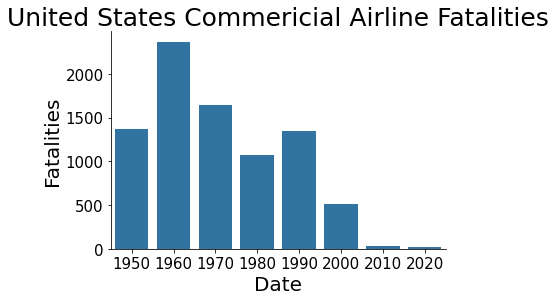

In [27]:
fatalities_per_decade = df["Fatalities"].groupby((df["Date"].dt.year//10)*10).sum().reset_index()
# fatalities_per_year = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
plt.title("United States Commericial Airline Fatalities", fontsize=25)
sns.barplot(x="Date", y="Fatalities", data=fatalities_per_decade);

### Commercial Airplane Speeds Over Time
Data was manually collected

In [28]:
df = pd.read_csv("../raw_data/government/aviation/commercial_airplane_speeds.txt")
df.head()

,Plane,Year,Cruise Speed,Top Speed,Source
0,Boeing 247,1933,189,200,https://g.co/kgs/76ALY6
1,Douglas DC-3,1935,207,257,https://g.co/kgs/hTVUaT
2,Douglas DC-4,1942,227,280,https://g.co/kgs/estQje
3,Lockhead 749,1947,275,347,https://aeropedia.com.au/content/lockheed-l-7...
4,Boeing 707,1958,604,627,https://en.wikipedia.org/wiki/Boeing_707


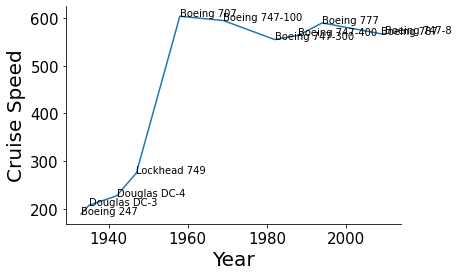

In [29]:
axes = sns.lineplot(x="Year", y="Cruise Speed", data=df)

for _, row in df.iterrows():
    axes.text(row.Year, row["Cruise Speed"], row.Plane)

### Prices
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SETG01?output_view=data)

In [30]:
airline_fares = pd.read_excel("../raw_data/government/aviation/airline_fares.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
airline_fares = helper.format_year_month_table(airline_fares)

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [31]:
cpi_relative_to_1970 = helper.percent_change_relative_to(cpi_data, date="1970-01-01", column_name="CPI")
airline_fares_relative_to_1970 = helper.percent_change_relative_to(airline_fares, date="1970-01-01", column_name="Value")

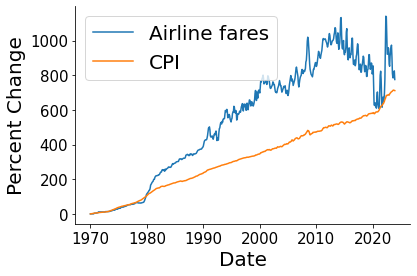

In [32]:
sns.lineplot(x="Date", y="Percent Change", data=airline_fares_relative_to_1970, label="Airline fares")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1970, label="CPI");

### General Aviation Planes
Raw data pulled from [here](https://gama.aero/facts-and-statistics/statistical-databook-and-industry-outlook/annual-data/)

In [33]:
general_aviation_plane_shipments = pd.read_csv("../raw_data/government/aviation/general_aviation_plane_shipments.txt", sep="\t")
general_aviation_plane_shipments["Grand Total"] = general_aviation_plane_shipments["Grand Total"].str.replace(' ', '').str.replace(",", "").astype(int)

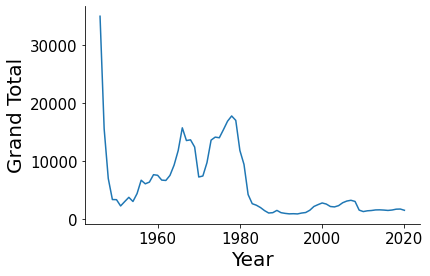

In [34]:
sns.lineplot(x="Year", y="Grand Total", data=general_aviation_plane_shipments);

## Construction

### Building Cost Index
Raw data pulled from [here](https://www.enr.com/economics/historical_indices/building_cost_index_history)

In [35]:
building_cost_index_annual_average = pd.read_csv("../raw_data/government/construction/building_cost_index_annual_average.txt")
building_cost_index_annual_average["Date"] = pd.to_datetime(building_cost_index_annual_average["Year"], format='%Y')

In [36]:
building_cost_index = pd.read_csv("../raw_data/government/construction/building_cost_index.txt").drop(columns=["AVG"])
building_cost_index = helper.format_year_month_table(building_cost_index, "BCI")

building_cost_index = pd.concat([building_cost_index, building_cost_index_annual_average])
building_cost_index = building_cost_index.sort_values(by="Date").reset_index(drop=True)

In [37]:
cpi_relative_to_1960 = helper.percent_change_relative_to(cpi_data, date="1960-01-01", column_name="CPI")
building_cost_index_relative_to_1960 = helper.percent_change_relative_to(building_cost_index, date="1960-01-01", column_name="BCI")

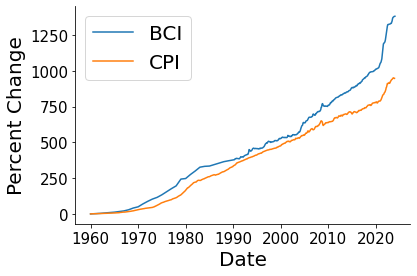

In [38]:
sns.lineplot(x="Date", y="Percent Change", data=building_cost_index_relative_to_1960, label="BCI")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1960, label="CPI");

## Education

### Public school employement
Raw data pulled from [here](https://nces.ed.gov/programs/digest/d22/tables/dt22_213.10.asp)

In [39]:
public_school_employment = pd.read_csv("../raw_data/government/education/public_school_employment.txt")

In [40]:
public_school_employment["Students"] = public_school_employment["Teachers"] * public_school_employment["Teachers per student"]

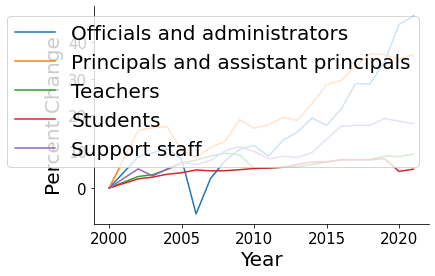

In [41]:
for column_name in ["Officials and administrators", "Principals and assistant principals", "Teachers", "Students", "Support staff"]:
    data = helper.percent_change_relative_to(public_school_employment, 2000, column_name)
    
    sns.lineplot(x="Year", y="Percent Change", data=data, label=column_name)

### Educational Attainment
Raw data pulled from [here](https://nces.ed.gov/programs/digest/d22/tables/xls/tabn104.20.xls)

In [42]:
educational_attainment = pd.read_csv("../raw_data/government/education/educational_attainment.txt")

educational_attainment["Date"] = pd.to_datetime(educational_attainment["Year"], format='%Y')
educational_attainment = educational_attainment.sort_values(by="Date").reset_index(drop=True)

In [43]:
# Bachelors degrees relative to 1970
bachelors_degree = educational_attainment[educational_attainment["Degree"] == "Bachelor's degree"]
bachelors_degree_relative_to_1970 = helper.percent_change_relative_to(bachelors_degree.reset_index(drop=True), "1970-01-01", "Percent")

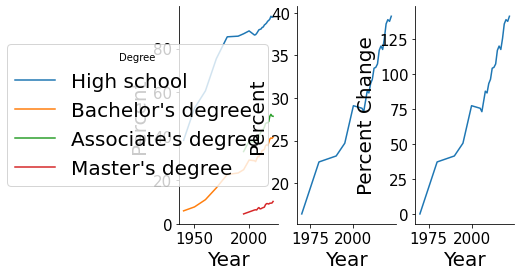

In [44]:
plt.subplot(1, 3, 1)
sns.lineplot(x="Year", y="Percent", data=educational_attainment, hue="Degree")

plt.subplot(1, 3, 2)
sns.lineplot(x="Year", y="Percent", data=bachelors_degree_relative_to_1970)

plt.subplot(1, 3, 3)
sns.lineplot(x="Year", y="Percent Change", data=bachelors_degree_relative_to_1970);

### College Tuition
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SEEB01?output_view=data)

In [45]:
college_tuition = pd.read_excel("../raw_data/government/education/college_tuition_and_fees.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
college_tuition = helper.format_year_month_table(college_tuition)

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [46]:
# Compute CPI relative to 1978 to match tuition data
cpi_relative_to_1978 = helper.percent_change_relative_to(cpi_data, date="1978-01-01", column_name="CPI")
college_tuition_relative_to_1978 = helper.percent_change_relative_to(college_tuition, date="1978-01-01", column_name="Value")

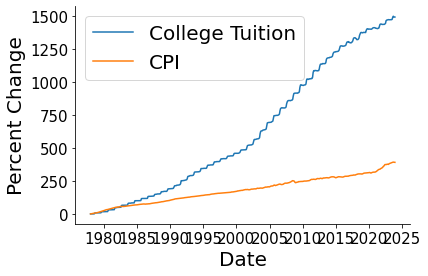

In [47]:
sns.lineplot(x="Date", y="Percent Change", data=college_tuition_relative_to_1978, label="College Tuition")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1978, label="CPI");

### Enrollment
Raw data pulled from [here](https://educationdata.org/college-enrollment-statistics)

In [48]:
college_enrollment = pd.read_csv("../raw_data/government/education/college_enrollment.txt")

college_enrollment["Year"] = pd.to_datetime(college_enrollment["Year"], format='%Y')
college_enrollment = college_enrollment.sort_values(by="Year").reset_index(drop=True)
helper.percent_change_relative_to(college_enrollment, "1970-01-01", "Total Enrollment").tail()

,Year,Total Enrollment,Percent Public Institution Enrollment,Percent Change
53,2019-01-01,19630178,73.88,128.766304
54,2020-01-01,19027410,72.97,121.741762
55,2021-01-01,18659851,72.58,117.458300
56,2022-01-01,18961280,73.12,120.971095
57,2023-01-01,18939568,73.19,120.718068


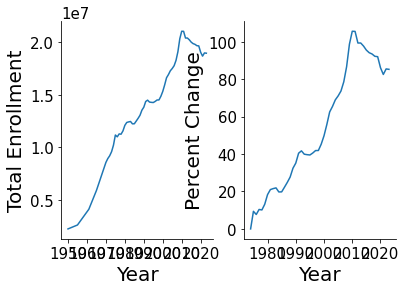

In [49]:
plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Total Enrollment", data=college_enrollment)

plt.subplot(1, 2, 2)
college_enrollment = helper.percent_change_relative_to(college_enrollment, "1974-01-01", "Total Enrollment")
sns.lineplot(x="Year", y="Percent Change", data=college_enrollment);

### Secondary Institutions
Raw data pulled from here [here](https://nces.ed.gov/programs/digest/d22/tables/dt22_317.10.asp)

In [50]:
secondary_institutions = pd.read_excel("../raw_data/government/education/post_secondary_institutions.xlsx", header=3)

secondary_institutions["Year"] = secondary_institutions["Year"].apply(lambda x: x.split("-")[0])
secondary_institutions["Date"] = pd.to_datetime(secondary_institutions["Year"], format='%Y')
secondary_institutions = secondary_institutions.sort_values(by="Date").reset_index(drop=True)

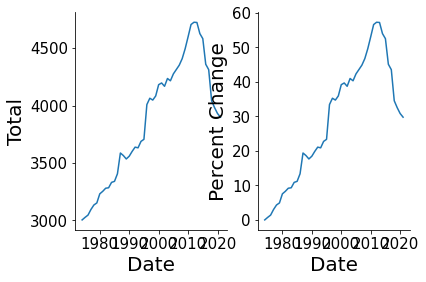

In [51]:
secondary_institutions = helper.percent_change_relative_to(secondary_institutions, "1974-01-01", "Total")

plt.subplot(1, 2, 1)
sns.lineplot(x="Date", y="Total", data=secondary_institutions)

plt.subplot(1, 2, 2)
sns.lineplot(x="Date", y="Percent Change", data=secondary_institutions);

## Energy

### Energy Consumption
Raw data pulled from [here](https://www.eia.gov/energyexplained/us-energy-facts/) and [here](https://www.eia.gov/totalenergy/data/monthly/xls/Table_D1.xlsx)

In [52]:
estimated_energy_consumption = pd.read_csv("../raw_data/government/energy/estimated_energy_consumption.csv")

energy_consumption = pd.read_csv("../raw_data/government/energy/primary-consumption-by-major-source.csv")
ENERGY_TYPES = ["Coal", "Natural gas", "Petroleum", "Nuclear", "Renewables"]
energy_consumption["Total"] = energy_consumption[ENERGY_TYPES].sum(axis=1)

energy_consumption = pd.concat([estimated_energy_consumption, energy_consumption])
energy_consumption = pd.melt(energy_consumption, id_vars=["Year"], var_name="Type", value_name="Quads")
energy_consumption = energy_consumption.loc[energy_consumption["Type"].isin(ENERGY_TYPES)]

total_consumption = energy_consumption.drop(columns=["Type"]).groupby("Year").sum().reset_index()

<Axes: xlabel='Year', ylabel='Quads'>

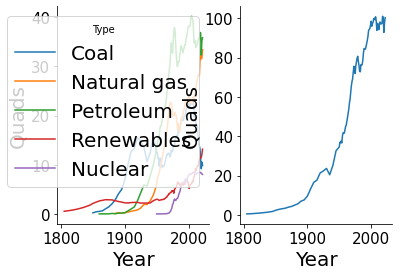

In [53]:
plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Quads", data=energy_consumption, hue="Type")

plt.subplot(1, 2, 2)
sns.lineplot(x="Year", y="Quads", data=total_consumption)

### Energy Consumption Per Capita

In [54]:
for index, row in total_consumption.iterrows():
    population_index = np.argmin(np.abs(population.Year.values - row.Year))
    total_consumption.at[index, "Per Capita"] = row.Quads / population.iloc[population_index].Population

<Axes: xlabel='Year', ylabel='Per Capita'>

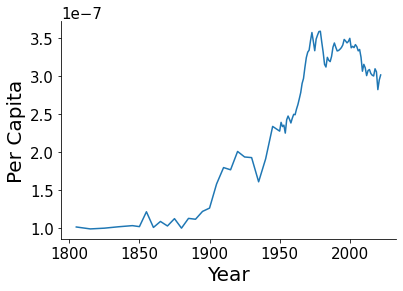

In [55]:
sns.lineplot(x="Year", y="Per Capita", data=total_consumption)

### Nuclear reactor cost
Data provided from authors

In [56]:
reactors = pd.read_excel("../raw_data/government/energy/Lovering2016_OCC_Nuclear_Seven_Countries.xlsx", header=0)
reactors = reactors[reactors.Country == "US"].reset_index(drop=True)
reactors["Duration"] = reactors.Comm_Op_Year - reactors.Constr_Year

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<Axes: xlabel='Constr_Year', ylabel='Duration'>

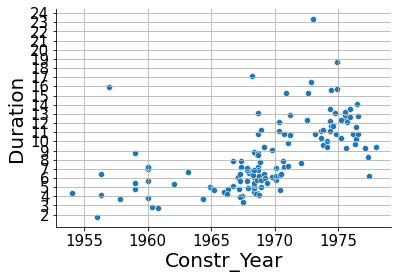

In [57]:
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(2, 25))
plt.grid()
sns.scatterplot(x="Constr_Year", y="Duration", data=reactors)

<Axes: xlabel='Duration', ylabel='OCC'>

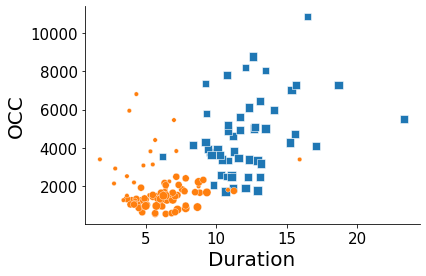

In [58]:
reactors_after_tmi = reactors[reactors.Note == "Completed after TMI"]
point_size = pd.cut(reactors_after_tmi.Capacity_MW, bins=[0, 1, 500, 1000, 1500], labels=[1, 20, 50, 70]).values
sns.scatterplot(x="Duration", y="OCC", data=reactors_after_tmi, marker="s", s=point_size)

reactors_before_tmi = reactors[reactors.Note != "Completed after TMI"]
point_size = pd.cut(reactors_before_tmi.Capacity_MW, bins=[0, 1, 500, 1000, 1500], labels=[1, 20, 50, 70]).values
sns.scatterplot(x="Duration", y="OCC", data=reactors_before_tmi, s=point_size)

## Medical

Approvals data from [here](https://www.fda.gov/about-fda/histories-fda-regulated-products/summary-nda-approvals-receipts-1938-present)

Orphan data from [here](https://www.fda.gov/news-events/fda-voices/cder-continues-make-rare-diseases-priority-drug-approvals-and-programming-speed-therapeutic) and [here](https://www.raps.org/News-and-Articles/News-Articles/2020/1/FDA-2019-Continues-Uptick-in-Orphan-Drug-Approval)

[R&D Spending per year](https://www.cbo.gov/system/files/2021-04/57025-Data.xlsx)

In [59]:
fda_approvals = pd.read_csv("../raw_data/government/medical/fda_applications.txt").iloc[20:]
fda_approvals["Percent Orphans"] = fda_approvals["Orphans"] / fda_approvals["New Molecular Entities"]

<Axes: xlabel='Year', ylabel='Percent Orphans'>

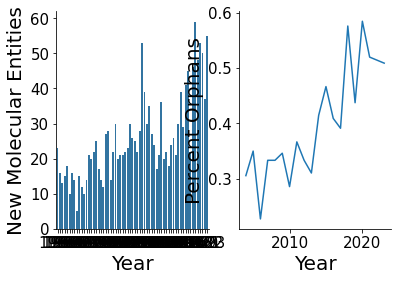

In [60]:
plt.subplot(1, 2, 1)
sns.barplot(x="Year", y="New Molecular Entities", data=fda_approvals)

plt.subplot(1, 2, 2)
sns.lineplot(x="Year", y="Percent Orphans", data=fda_approvals)

## Railroads
### Passenger Train Spees

In [61]:
df = pd.read_csv("../raw_data/government/transportation/passenger_train_speeds.txt")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df.head()

,Km/H,MPH,Train,Location,Date,Comments,Country
0,200.0,120,Class 1000 Shinkansen,Kamonomiya test track in Odawara now part of T...,1962-10-31,NaN,Japan
1,256.0,159,Class 1000 Shinkansen,Kamonomiya test track,1963-03-30,Former world speed record for EMU trains.,Japan
2,286.0,178,Class 951 Shinkansen,San'yō Shinkansen,1972-02-24,Former world speed record for EMU trains.,Japan
3,319.0,198,Class 961 Shinkansen,Oyama test track now part of Tōhoku Shinkansen,1979-12-07,Former world speed record for EMU trains.,Japan
4,326.0,203,300 series,Tōkaidō Shinkansen,1991-02-28,NaN,Japan


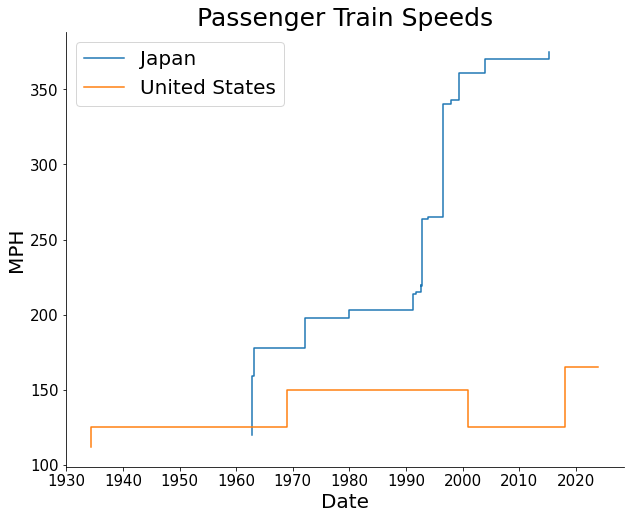

In [62]:
plt.figure(figsize=(10,8))
axes = sns.lineplot(x="Date", y="MPH", data=df, hue="Country", drawstyle="steps")
plt.title("Passenger Train Speeds")
plt.legend()

plt.savefig("../images/passenger_train_speeds.png")

## All
- [Television](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SERA01)
- [Airline fares](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SETG01)
- [Hospital services](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEMD01)
- [Transportation services](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SAS4)
- [Energy](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SA0E)
- [Cellphone services](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEED03)
- [Shelter](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SAH1)
- [New cars](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SS45011)
- [Computers](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEEE01)
- [Computer software](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEEE02)
- [Medical care](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SAM)

In [63]:
sectors = [
    ["cellphone_services"],
    ["television"],
    ["energy", "energy"],
    ["medical", "hospital_services"],
    ["aviation", "airline_fares"],
    ["shelter"],
    ["food"],
    ["computer_software"],
    ["new_cars"],
    ["computers"],
    ["medical", "medical_care"],
    ["education", "college_tuition"],
]

In [64]:
df = pd.DataFrame()

for description in sectors:
    path = os.path.join(*description)
    data = pd.read_csv(f"../raw_data/government/{path}.csv")
    data["Label"] = data["Label"].replace({"Half1": "Jan", "Half2": "Jul"}, regex=True)
    
    data["Date"] = pd.to_datetime(data['Label'], format='%Y %b')
    data["Category"] = description[-1]
    data = helper.percent_change_relative_to(data, "2000-01-01", "Value")
    df = pd.concat([df, data])

In [65]:
data = building_cost_index.rename(columns={"BCI": "Value"}).dropna().reset_index(drop=True)
data["Category"] = "Building"
building_cost_index_relative_to_2000 = helper.percent_change_relative_to(data, date="2000-01-01", column_name="Value")
df = pd.concat([df, building_cost_index_relative_to_2000])

In [66]:
cpi_relative_to_2000 = helper.percent_change_relative_to(cpi_data, "2000-01-01", "CPI")

In [67]:
offsets = {
    "energy": 5,
    "building": -2,
    "medical_care": 2,
    "food": -5,
    "television": -8,
    "shelter": -2,
    "airline_fares": -5,
}

In [68]:
sorted_categories = df[df["Date"] == "2023-12-01"].sort_values(by="Percent Change").Category.unique().tolist()
color_palette = sns.color_palette("coolwarm", len(sorted_categories))

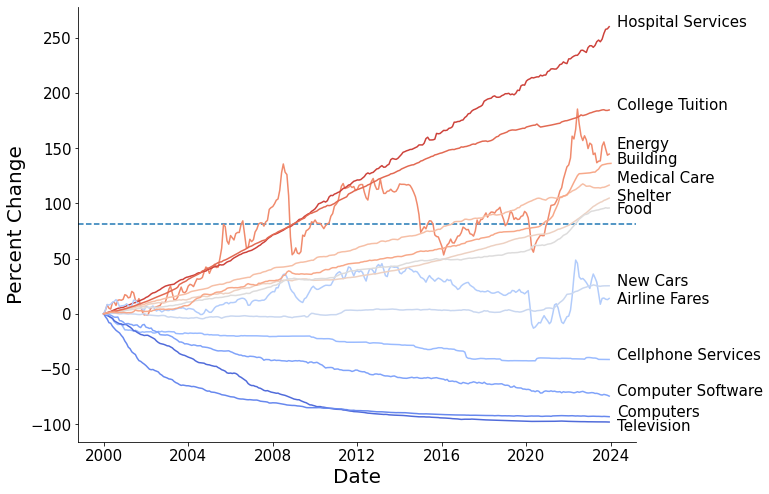

In [69]:
average_by_year = df[["Year", "Percent Change", "Category"]].groupby(["Category", "Year"]).mean().reset_index()

plt.figure(figsize=(10, 8))
# sns.lineplot(x="Date", y="Percent Change", data=df, hue="Category")
plt.axhline(y=cpi_relative_to_2000["Percent Change"].values[-1], ls="--")
plt.legend([],[], frameon=False)

for category_name in df.Category.unique():
    category = df[df.Category == category_name]
    last_y = category["Percent Change"].values[-1]

    color = color_palette[sorted_categories.index(category_name)]
    sns.lineplot(x="Date", y="Percent Change", data=category, color=color)

    offset = offsets.get(category_name, 0)

    ax = plt.gca()
    xticks = ax.get_xticks()
    
    category_name = category_name.replace("_", " ").title()
    plt.text(xticks[-2] + 100, last_y + offset, category_name, fontsize=15)

plt.savefig("../images/stagnation_plot.png")

## Total Pages in Federal Regulations
Raw data pulled from [here](https://regulatorystudies.columbian.gwu.edu/sites/g/files/zaxdzs4751/files/2022-11/totalpagescodefedreg_11-01-2022.csv)

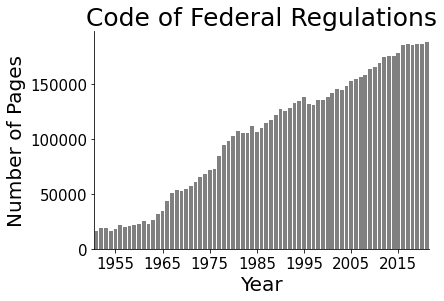

In [70]:
total_pages = pd.read_csv("../raw_data/government/total_pages_code_of_federal_regulations.txt")
ax = sns.barplot(x="Year", y="Total Pages", data=total_pages, color="gray")

years = sorted(total_pages.Year.values)
plt.title("Code of Federal Regulations", fontsize=25)
plt.ylabel("Number of Pages")
ax.set_xticks(range(4, len(years), 10), years[4::10]);

plt.savefig("../images/total_pages_cfr.png")

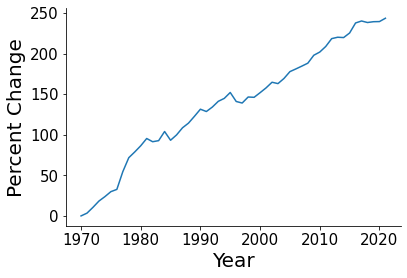

In [71]:
total_pages = helper.percent_change_relative_to(total_pages, 1970, "Total Pages")

ax = sns.lineplot(x="Year", y="Percent Change", data=total_pages)